In [2]:
from collections.abc import Callable
import jax
import jax.numpy as jnp
from typing import Union
import jax.random as jr
from jax import grad, jit, vmap, pmap
from jax import lax
import numpy as np
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import equinox as eqx
from typing import Union, Callable
import equinox as eqx
import torchvision.transforms as transforms
import random
import networkx as nx
import re
import torch
from torchvision import datasets, transforms

In [3]:
# Hyperparameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
batch_size = 32
num_steps = 100000
image_size = (64, 64, 1)
height, width, channels = image_size
latent_size = 100

In [4]:
# Load the MNIST dataset using torchvision
transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

data = torchvision.datasets.MNIST(root="./data", transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True, num_workers=2
)

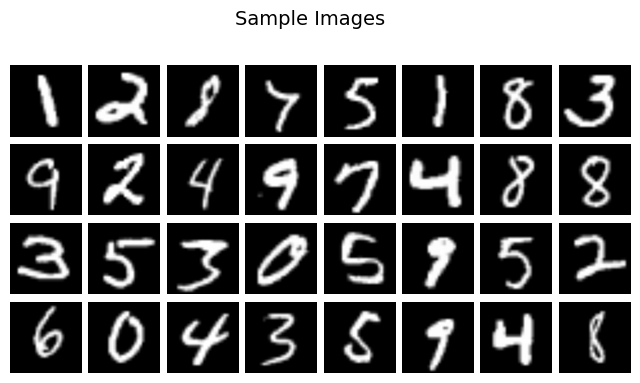

In [5]:
images, labels = next(iter(dataloader))

plot_sample = images.permute(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Sample Images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [6]:
class Generator(eqx.Module):
    linear_layer: eqx.nn.Linear
    downsample_layers_01: list

    def __init__(self, latent_size, key: jr.PRNGKey):
        keys = jr.split(key, 6)  # Precisamos de 6 chaves, uma para cada camada

        # Primeiro, transforma o vetor latente em um tensor que pode ser processado por camadas convolucionais
        self.linear_layer = eqx.nn.Linear(in_features=latent_size, out_features=512 * 1 * 1, key=keys[0])

        self.downsample_layers_01 = [
            eqx.nn.BatchNorm(input_size=512, axis_name=("batch",)),
            jax.nn.leaky_relu,

            # Upsampling progressivo
            eqx.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=256, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[2]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[3]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[4]),
            eqx.nn.BatchNorm(input_size=32, axis_name=("batch",)),
            jax.nn.leaky_relu,


            eqx.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[5]),
            eqx.nn.BatchNorm(input_size=16, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[6]),
            jax.nn.tanh  # Gera uma imagem com valores de pixel no intervalo [-1, 1]
        ]

    def __call__(self, x, state):
        x = self.linear_layer(x)
        x = x.reshape(x.shape[0], 1, 1)  # Redimensiona para a forma desejada para convolução


        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)

        return x, state

In [7]:
class Discriminator(eqx.Module):
    downsample_layers_01: list
    linear_layer: eqx.nn.Linear

    def __init__(self, key: jr.PRNGKey):
        keys = jr.split(key, 6)
        #64x64x1
        self.downsample_layers_01 = [
            eqx.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[0]),
            jax.nn.leaky_relu,

            eqx.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[2]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[3]),
            eqx.nn.BatchNorm(input_size=256, axis_name=("batch",)),
            jax.nn.leaky_relu,

            eqx.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0, use_bias=False, key=keys[4]),
        ]

        self.linear_layer = eqx.nn.Linear(in_features=512, out_features=1, key=keys[5])

    def __call__(self, x, state):
        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)


        x = x.reshape(x.shape[0], -1)  # Flatten the tensor

        x = self.linear_layer(x)  # Linear layer for classification

        return x, state


In [8]:
def draw_model(model, preview=False):
    G = nx.DiGraph()
    offset = 0
    y_step = 0.8
    size_multiplier = 300
    channels, width, height = 1, 64, 64  # Assuming input size of 64x64x1

    # Initialize sizes with default value for each layer
    sizes = [size_multiplier for _ in model.downsample_layers_01] + [size_multiplier]  # +1 for the linear layer

    for i, layer in enumerate(model.downsample_layers_01):
        label = re.search(r'[^.]*$', str(type(layer))).group(0)
        label = re.sub(r"'>$", "", label)    
        is_conv = isinstance(layer, eqx.nn.Conv2d)
        if is_conv:
            sizes[i] = 4*size_multiplier  # Update size for conv layers
            stride = layer.stride[0]
            in_channels = layer.weight.shape[1]
            out_channels = layer.weight.shape[0]
            label += f" (-, {in_channels}, {width}, {height})"
            if stride == 2:
                width //= 2
                height //= 2
            label += f"\n {' '*len(label)}(-, {out_channels}, {width}, {height})"

        G.add_node(i, label=label)
        G.add_edge(i-1, i) if (i != 0) else None

    # Adding the linear layer
    i += 1
    G.add_node(i, label="Linear")
    G.add_edge(i-1, i)

    positions = {j: (offset, -j*y_step) for j in range(i + 1)}
    height = len(model.downsample_layers_01) + 1 if not preview else 15
    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
    fig = plt.figure(figsize=(5, 5+height*y_step))
    plt.title(str(type(model)))
    nx.draw(G, with_labels=True, labels=node_labels, pos=positions, node_color="w", node_size=sizes, font_family='monospace')
    plt.ylim(-1.1*(5 + height*y_step), 0.5)
    return fig

(100, 100)
-0.9341284
0.77789843


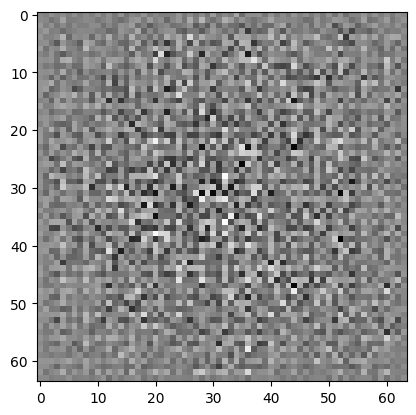

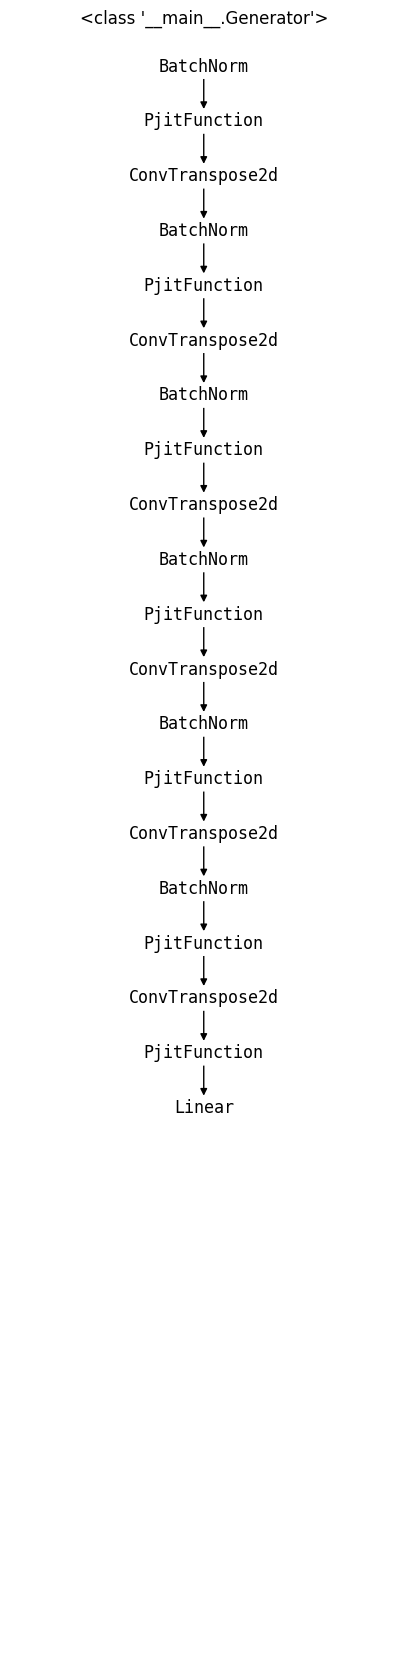

In [11]:
key = jr.PRNGKey(1)
latent_size = 100
input_size = (1, 1, 1)

generator, state = eqx.nn.make_with_state(Generator)(latent_size, key)

test_tensor = jr.normal(key, (100, latent_size))

print(test_tensor.shape)

output, state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

images = output
print(images.min())
print(images.max())
images = (images - images.min()) / (images.max() - images.min())
plt.imshow(images[0, 0], cmap='gray')
plt.show()
fig = draw_model(generator)
plt.show()

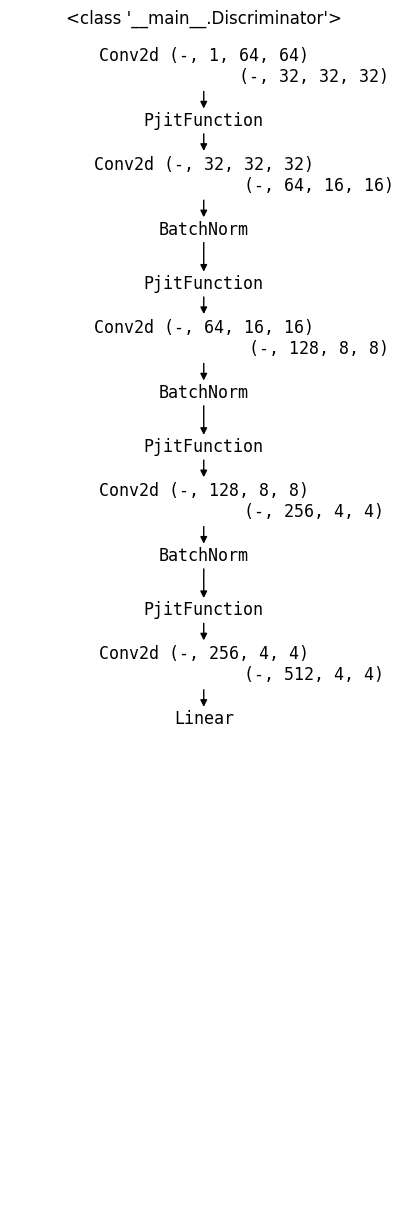

In [12]:
seed = 2
key = jr.PRNGKey(seed)
mkey, xkey, xkey2 = jr.split(key, 3)
input_shape = (64, 64, 1)

#Inicia o modelo e o estado com as variaveis que foram definidas no Init
discriminator, state = eqx.nn.make_with_state(Discriminator)(key)

test_tensor = jr.normal(xkey, (5, 1, 64, 64))

output, state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

fig = draw_model(discriminator)
plt.show()

In [13]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_generator(generator, discriminator, real_labels, discriminator_state, generator_state, key):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size))

    fake_batch, generator_state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(fake_batch, discriminator_state)

    loss = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    return loss, (discriminator_state, generator_state, key)

In [14]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_discriminator(discriminator, generator, fake_labels, real_batch, real_labels, discriminator_state, generator_state, key):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size))

    fake_batch, generator_state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(fake_batch, discriminator_state)
    loss1 = optax.sigmoid_binary_cross_entropy(pred_y, fake_labels).mean()

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(real_batch, discriminator_state)

    loss2 = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    loss = (loss1 + loss2) / 2

    return loss, (discriminator_state, generator_state, key)

In [15]:
@eqx.filter_jit
def step_discriminator(
    discriminator: Discriminator,
    generator: Generator,
    real_batch: jnp.ndarray,
    discriminator_optimizer: optax.GradientTransformation,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    key: jr.PRNGKey,
):

    fake_labels = jnp.zeros(batch_size)
    real_labels = jnp.ones(batch_size)

    # Calcula a perda e os gradientes para o discriminador
    (loss, (discriminator_state, generator_state, key)), grads = compute_grads_discriminator(
        discriminator,
        generator,
        fake_labels,
        real_batch,
        real_labels,
        discriminator_state,
        generator_state,
        key,
    )

    # Atualiza os parâmetros do discriminador com base nos gradientes
    updates, opt_state = discriminator_optimizer.update(
        grads, discriminator_opt_state, discriminator
    )
    discriminator = eqx.apply_updates(discriminator, updates)

    # Retorna a perda e os estados atualizados
    return loss, discriminator, opt_state, generator_state, discriminator_state, key



In [16]:
@eqx.filter_jit
def step_generator(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_state: eqx.nn.State,
    generator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    real_labels = jnp.ones(batch_size)

    (
        loss,
        (discriminator_state, generator_state, key),
    ), grads = compute_grads_generator(
        generator, discriminator, real_labels, discriminator_state, generator_state, key
    )

    updates, opt_state = generator_optimizer.update(grads, generator_opt_state)
    generator = eqx.apply_updates(generator, updates)

    return loss, generator, opt_state, discriminator_state, generator_state, key

In [17]:

def train(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    discriminator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    data_loader: torch.utils.data.DataLoader,
    num_steps: int,
    key: jr.PRNGKey,
    print_every: int = 1000,
):
    generator_losses = []
    discriminator_losses = []
    key, subkey = jr.split(key, 2)
    test_noises = []
    
    for _ in range(8):
        randkey = jr.PRNGKey(random.randint(0, 10000))
        test_noises.append(jr.normal(randkey, (1, latent_size)))

    def infinite_trainloader():
        while True:
            yield from data_loader

    for step, batch in zip(range(num_steps), infinite_trainloader()):
        images, labels = batch

        (
            discriminator_loss,
            discriminator,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
            
        ) = step_discriminator(
            discriminator,
            generator,
            images.numpy(),
            discriminator_optimizer,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
        )

        (
            generator_loss,
            generator,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        ) = step_generator(
            generator,
            discriminator,
            generator_optimizer,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        )

        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

        if (step % print_every) == 0 or step == num_steps - 1:
            print(
                f"Step: {step}/{num_steps}, Generator loss: {generator_loss}, "
                f"Discriminator loss: {discriminator_loss}"
            )
            
            batch_model = jax.vmap(generator, axis_name="batch", in_axes=(0, None))
            fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 1))
            for ax, test_noise in zip(axes.tolist(), test_noises):
                images, _ = batch_model(test_noise, generator_state)
                ax.imshow(jnp.transpose(images[0], (1, 2, 0)), cmap="gray")
                ax.set_axis_off()
            plt.show()

    return (
        generator,
        discriminator,
        generator_state,
        discriminator_state,
        generator_losses,
        discriminator_losses,
        key,
    )

In [19]:
key = jr.PRNGKey(2003)

key, gen_key, disc_key = jr.split(key, 3)

generator = Generator(latent_size, key=gen_key)
discriminator = Discriminator(key=disc_key)
generator_state = eqx.nn.State(generator)
discriminator_state = eqx.nn.State(discriminator)

generator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)
discriminator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)

generator_opt_state = generator_optimizer.init(eqx.filter(generator, eqx.is_array))
discriminator_opt_state = discriminator_optimizer.init(eqx.filter(discriminator, eqx.is_array))

Step: 0/100000, Generator loss: 0.3283179700374603, Discriminator loss: 0.7599548697471619


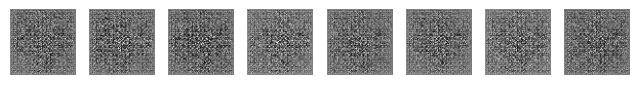

Step: 1000/100000, Generator loss: 21.48930549621582, Discriminator loss: 0.00010069506242871284


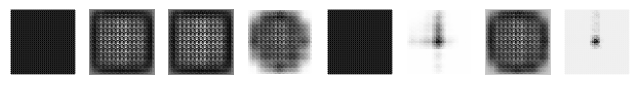

Step: 2000/100000, Generator loss: 13.221156120300293, Discriminator loss: 0.005511171650141478


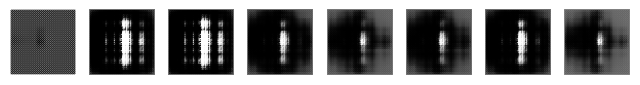

Step: 3000/100000, Generator loss: 8.394942283630371, Discriminator loss: 0.002100270474329591


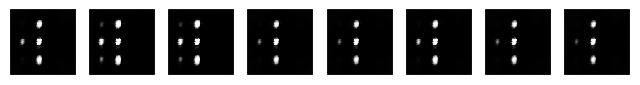

Step: 4000/100000, Generator loss: 6.466693878173828, Discriminator loss: 0.057085976004600525


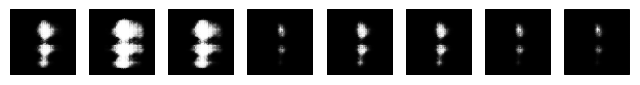

In [20]:

(generator, discriminator, generator_state, discriminator_state, generator_losses, discriminator_losses, key,) = train(generator, discriminator, generator_optimizer, discriminator_optimizer, generator_opt_state, discriminator_opt_state, generator_state, discriminator_state, dataloader, num_steps, key,)

In [ ]:
key, subkey = jr.split(key)
noise = jr.normal(subkey, (1000, latent_size))


@eqx.filter_jit
def evaluate(model, xx):
    out, _ = jax.vmap(model)(xx)
    return out


inference_gen = eqx.nn.inference_mode(generator)
inference_gen = eqx.Partial(inference_gen, state=generator_state)

generated_images = evaluate(inference_gen, noise)

inference_discriminator = eqx.nn.inference_mode(discriminator)
inference_discriminator = eqx.Partial(
    inference_discriminator, state=discriminator_state
)

logits = evaluate(inference_discriminator, generated_images)

plot_sample = generated_images[
    jax.lax.top_k(jax.nn.sigmoid(logits).squeeze(), 32)[1]
].transpose(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Top generated fake images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

NameError: name 'generator_state' is not defined